# Modèles ARMA sur l'indice de production industrielle du log du commerce d'éléctricité

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
sns.set()
%matplotlib inline
import scipy.stats as stats

#### Chargement des données brutes

In [43]:
import os
os.chdir("/Users/admin/Desktop/ENSAE/2A/S2/Séries temporelles/Projet/TimeSeries")

In [44]:
dfE = pd.read_csv(
   "Electricite/valeurs_mensuelles.csv",
    sep=";",
    skiprows=[1, 2],
    index_col="Libellé",
    parse_dates=["Libellé"])
dfE.columns = ["Electricite","ToDelete"]
del(dfE["ToDelete"])

log_dfE = np.log(dfE)
log_dfE.head()

,Electricite
Libellé,
1990-01-01,4.455277
1990-02-01,4.209606
1990-03-01,4.228147
1990-04-01,4.173618
1990-05-01,3.936130


#### Chargement des données stationnarisées

In [45]:
s = pd.read_csv("Electricite/stationnaire.csv", parse_dates=[0], header=None, index_col=0)
s.columns = ["Electricite"]
s.index.names = ['Date']
s.head()

,Electricite
Date,
1990-02-01,-0.125571
1990-03-01,0.067431
1990-04-01,0.115244
1990-05-01,-0.112320
1990-06-01,0.051904


## Etude et comparaison de différents modèles ARMA

### Sélection des ordres $p^*, q^*$

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Etude des autocorrélogrammes partiels et totaux de la série $\tilde{X_t}$

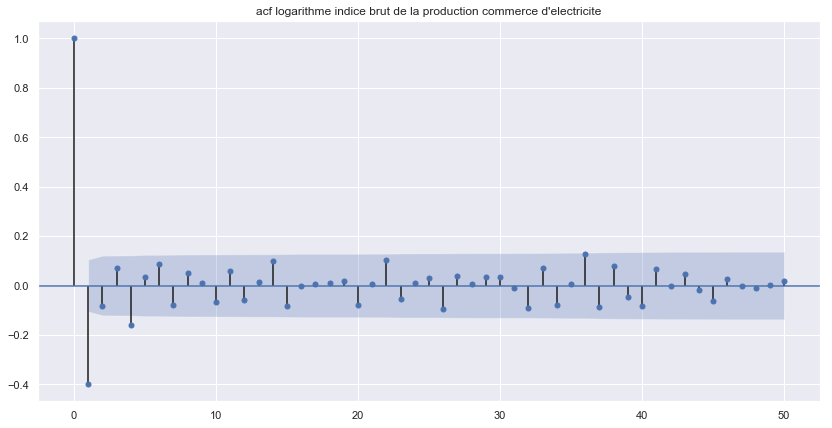

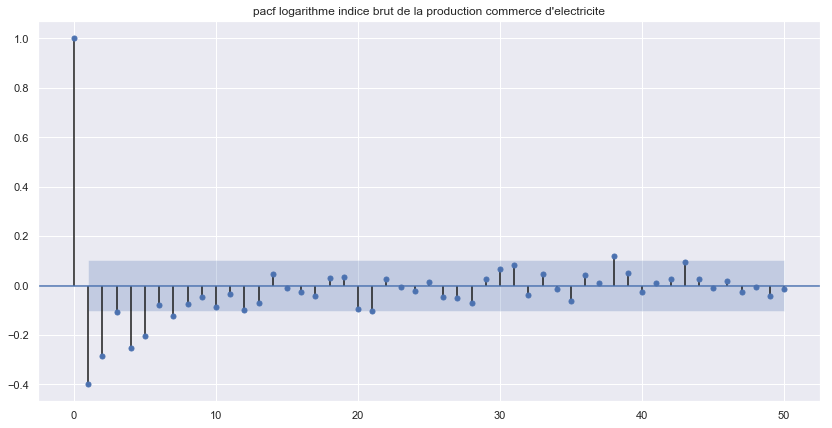

In [9]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(s, lags=50,
             title="acf logarithme indice brut de la production commerce d'electricite")
    #plt.savefig("Images/acf.png")

    plot_pacf(s, lags=50,
             title="pacf logarithme indice brut de la production commerce d'electricite")
    #plt.savefig("Images/pacf.png")

**Commentaires:** L'ordre $q$ vraisemblable $\in \{0, 1, 3, 4\}$

L'ordre $p$ vraisemblable $\in \{0, 1, 2, 3, 4, 5, 6, 7\}$


### Sélection de modèles ARMA

In [46]:
import warnings
warnings.filterwarnings("ignore")

In [47]:
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

On cherche à sélectionner parmi les modèles valides (dont les résidus sont des bruits blancs) et ayant un bon ajustement ceux qui ont les meilleurs critères d'information (AIC, BIC) et score MSE:

In [7]:
def evaluate_arma(dataset, p_values, q_values):

    N = dataset.shape[0]
    train = dataset.iloc[1:(N-6)]
    test = dataset.iloc[(N-6):N]
    
    info_criterium, ljung_box, pvalues_coef, mse = pd.DataFrame([],columns=["order","AIC","BIC","MSE"]), None, [], None

    for p in p_values:

        for q in q_values:

            my_order = (p, q)

            try:

                model = ARMA(dataset, order=my_order)
                model_fit = model.fit()

                # On verifie que toutes les p-value du test de Ljung-box sont bien supérieures à 0.05
                ljung_box = np.min(acorr_ljungbox(model_fit.resid)[1])

                if ljung_box > 0.05:

                    # On regarde l'ajustement des modèles valides

                    if p > 0:
                        pvalues_coef.append(model_fit.pvalues["ar.L" + str(p) +
                                                              ".Electricite"])
                    if q > 0:
                        pvalues_coef.append(model_fit.pvalues["ma.L" + str(q) +
                                                              ".Electricite"])

                    if max(pvalues_coef) < 0.05:
                        #modele bien ajusté

                        model_mse = ARMA(train, order=my_order).fit()
                        pred = model_mse.forecast(6)[0]
                        mse = mean_squared_error(pred,test)
                        
                        info_criterium = info_criterium.append(pd.Series({"order":my_order,
                                                                "AIC":model_fit.aic,
                                                                "BIC":model_fit.bic,
                                                                "MSE":mse}),
                                                                 ignore_index=True)
                        
                        
                        

                    pvalues_coef, mse = [], None

            except:

                print("je n'ai pas convergé : {}".format(my_order))
                continue
                
    #info_criterium.set_index("order",inplace=True)
    print("{} modèles sélectionnés".format(len(info_criterium)))
                

    return info_criterium

In [8]:
p_values = [0, 1, 2, 3, 4, 5, 6, 7]
q_values = [0, 1, 2, 3, 4]

In [199]:
%%time
df = evaluate_arma(s, p_values, q_values)

je n'ai pas convergé : (0, 4)
je n'ai pas convergé : (5, 2)
je n'ai pas convergé : (5, 3)
je n'ai pas convergé : (6, 4)
9 modèles sélectionnés
CPU times: user 58.2 s, sys: 4.07 s, total: 1min 2s
Wall time: 46.1 s


In [10]:
df.sort_values(by="AIC",axis=0)

,order,AIC,BIC,MSE
6,"(4, 4)",-1181.339093,-1142.788373,0.004092
5,"(4, 1)",-1180.929642,-1153.944138,0.004611
1,"(1, 1)",-1179.678125,-1164.257837,0.004543
0,"(0, 2)",-1179.292567,-1163.872280,0.004522
4,"(3, 3)",-1177.723612,-1146.883037,0.004172
2,"(2, 2)",-1177.641690,-1154.511258,0.004773
3,"(2, 3)",-1176.177085,-1149.191582,0.004842
8,"(7, 0)",-1169.640823,-1134.945176,0.004242
7,"(5, 0)",-1165.807874,-1138.822371,0.004742


In [202]:
df.sort_values(by="BIC",axis=0)

,order,AIC,BIC,MSE
1,"(1, 1)",-1179.678125,-1164.257837,0.004543
0,"(0, 2)",-1179.292567,-1163.872280,0.004522
2,"(2, 2)",-1177.641690,-1154.511258,0.004773
5,"(4, 1)",-1180.929642,-1153.944138,0.004611
3,"(2, 3)",-1176.177085,-1149.191582,0.004842
4,"(3, 3)",-1177.723612,-1146.883037,0.004172
6,"(4, 4)",-1181.339093,-1142.788373,0.004092
7,"(5, 0)",-1165.807874,-1138.822371,0.004742
8,"(7, 0)",-1169.640823,-1134.945176,0.004242


In [203]:
df.sort_values(by="MSE",axis=0)

,order,AIC,BIC,MSE
6,"(4, 4)",-1181.339093,-1142.788373,0.004092
4,"(3, 3)",-1177.723612,-1146.883037,0.004172
8,"(7, 0)",-1169.640823,-1134.945176,0.004242
0,"(0, 2)",-1179.292567,-1163.872280,0.004522
1,"(1, 1)",-1179.678125,-1164.257837,0.004543
5,"(4, 1)",-1180.929642,-1153.944138,0.004611
7,"(5, 0)",-1165.807874,-1138.822371,0.004742
2,"(2, 2)",-1177.641690,-1154.511258,0.004773
3,"(2, 3)",-1176.177085,-1149.191582,0.004842


### Etudes complémentaires des résidus

On regarde les autocorrélogrammes des résidus de chaque modèle

In [247]:
def test_res(order):
    arma_model = ARMA(s, order=order).fit()
    resid = arma_model.resid
    
    plot_acf(resid, lags=24)
    plt.show()    

In [208]:
ordre = df.order.values

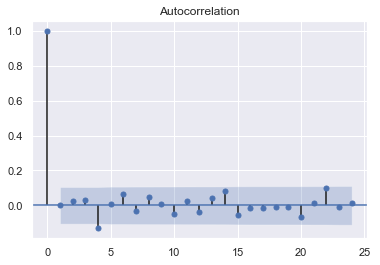

(-0.004652133134417465, 0.004652133134417465) ordre: (0, 2)


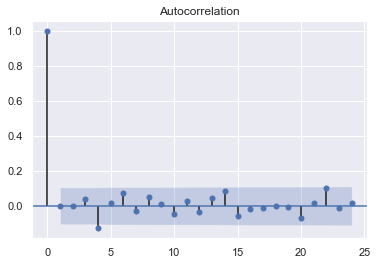

(-0.004649691852479468, 0.004649691852479468) ordre: (1, 1)


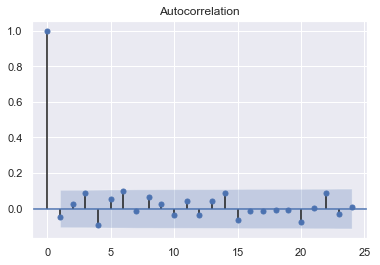

(-0.004634867422085119, 0.004634867422085119) ordre: (2, 2)


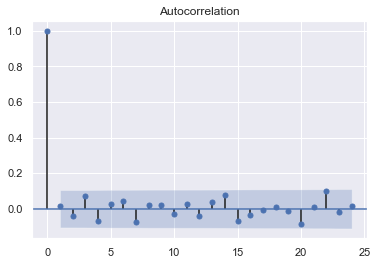

(-0.004635286254184447, 0.004635286254184447) ordre: (2, 3)


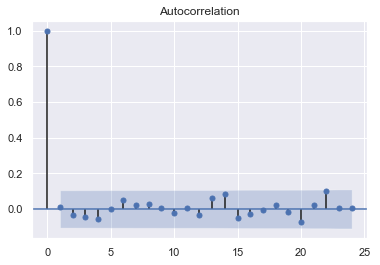

(-0.004609162684476449, 0.004609162684476449) ordre: (3, 3)


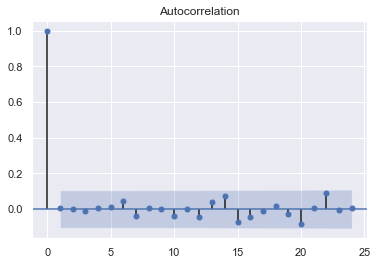

(-0.004602150978029043, 0.004602150978029043) ordre: (4, 1)


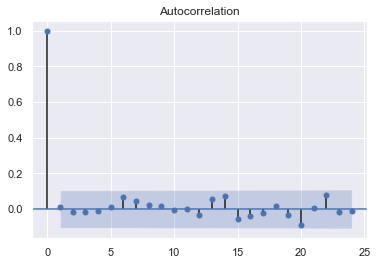

(-0.004563336686760367, 0.004563336686760367) ordre: (4, 4)


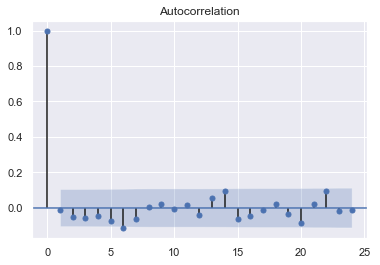

(-0.004700173428209644, 0.004700173428209644) ordre: (5, 0)


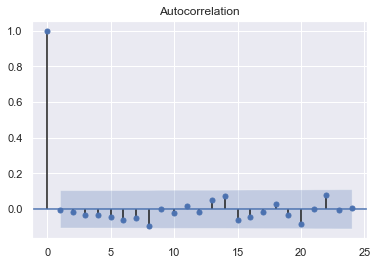

(-0.0046490969449194015, 0.0046490969449194015) ordre: (7, 0)


In [248]:
for order in ordre:
    test_res(order)

**Commentaires:** On élimine les modèles suivants: (0,2), (1,1) et (5,0).

In [210]:
delete = [(0,2),(1,1),(5,0)]

In [221]:
df_final = df[~df['order'].isin(delete)].reset_index(drop=True)

In [225]:
df_final.sort_values(by="AIC", axis=0)

,order,AIC,BIC,MSE
4,"(4, 4)",-1181.339093,-1142.788373,0.004092
3,"(4, 1)",-1180.929642,-1153.944138,0.004611
2,"(3, 3)",-1177.723612,-1146.883037,0.004172
0,"(2, 2)",-1177.641690,-1154.511258,0.004773
1,"(2, 3)",-1176.177085,-1149.191582,0.004842
5,"(7, 0)",-1169.640823,-1134.945176,0.004242


In [226]:
df_final.sort_values(by="BIC", axis=0)

,order,AIC,BIC,MSE
0,"(2, 2)",-1177.641690,-1154.511258,0.004773
3,"(4, 1)",-1180.929642,-1153.944138,0.004611
1,"(2, 3)",-1176.177085,-1149.191582,0.004842
2,"(3, 3)",-1177.723612,-1146.883037,0.004172
4,"(4, 4)",-1181.339093,-1142.788373,0.004092
5,"(7, 0)",-1169.640823,-1134.945176,0.004242


In [227]:
df_final.sort_values(by="MSE", axis=0)

,order,AIC,BIC,MSE
4,"(4, 4)",-1181.339093,-1142.788373,0.004092
2,"(3, 3)",-1177.723612,-1146.883037,0.004172
5,"(7, 0)",-1169.640823,-1134.945176,0.004242
3,"(4, 1)",-1180.929642,-1153.944138,0.004611
0,"(2, 2)",-1177.641690,-1154.511258,0.004773
1,"(2, 3)",-1176.177085,-1149.191582,0.004842


In [238]:
print(df_final.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &   order &          AIC &          BIC &       MSE \\
\midrule
0 &  (2, 2) & -1177.641690 & -1154.511258 &  0.004773 \\
1 &  (2, 3) & -1176.177085 & -1149.191582 &  0.004842 \\
2 &  (3, 3) & -1177.723612 & -1146.883037 &  0.004172 \\
3 &  (4, 1) & -1180.929642 & -1153.944138 &  0.004611 \\
4 &  (4, 4) & -1181.339093 & -1142.788373 &  0.004092 \\
5 &  (7, 0) & -1169.640823 & -1134.945176 &  0.004242 \\
\bottomrule
\end{tabular}



### Modèle retenu :

* $ARMA(4,4)$

In [48]:
arma_model = ARMA(s, order=(4,4)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Electricite   No. Observations:                  349
Model:                     ARMA(4, 4)   Log Likelihood                 600.670
Method:                       css-mle   S.D. of innovations              0.043
Date:                Tue, 14 May 2019   AIC                          -1181.339
Time:                        15:54:00   BIC                          -1142.788
Sample:                    02-01-1990   HQIC                         -1165.993
                         - 02-01-2019                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0013      0.001      2.310      0.021       0.000       0.002
ar.L1.Electricite     0.3690      0.406      0.909      0.364      -0.427       1.165
ar.L2.Electricite     0.2886      0.332      0.870      0.385      -0.361       0.938
ar.L3.Electricite     0.5939      0.192      3.095      0.002       0.218       0.970
ar.L4.Electricite    -0.2815      0.070     -4.011      0.000      -0.419      -0.144
ma.L1.Electricite    -1.0856      0.430     -2.527      0.012      -1.928      -0.243
ma.L2.Electricite    -0.1430      0.682     -0.210      0.834      -1.480       1.194
ma.L3.Electricite    -0.3420      0.277     -1.235      0.218      -0.885       0.201
ma.L4.Electricite     0.5785      0.197      2.935      0.004       0.192       0.965
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7055           -0.9466j            1.1806           -0.3519
AR.2           -0.7055           +0.9466j            1.1806            0.3519
AR.3            1.0186           -0.0000j            1.0186           -0.0000
AR.4            2.5025           -0.0000j            2.5025           -0.0000
MA.1           -0.7234           -1.0662j            1.2884           -0.3449
MA.2           -0.7234           +1.0662j            1.2884            0.3449
MA.3            1.0190           -0.0547j            1.0205           -0.0085
MA.4            1.0190           +0.0547j            1.0205            0.0085
-----------------------------------------------------------------------------
"""

In [254]:
for table in arma_model.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &   Electricite    & \textbf{  No. Observations:  } &    349     \\
\textbf{Model:}         &    ARMA(4, 4)    & \textbf{  Log Likelihood     } &  600.670   \\
\textbf{Method:}        &     css-mle      & \textbf{  S.D. of innovations} &   0.043    \\
\textbf{Date:}          & Sun, 28 Apr 2019 & \textbf{  AIC                } & -1181.339  \\
\textbf{Time:}          &     15:22:20     & \textbf{  BIC                } & -1142.788  \\
\textbf{Sample:}        &    02-01-1990    & \textbf{  HQIC               } & -1165.993  \\
\textbf{}               &   - 02-01-2019   & \textbf{                     } &            \\
\bottomrule
\end{tabular}
%\caption{ARMA Model Results}
\end{center}
\begin{center}
\begin{tabular}{lcccccc}
\toprule
                           & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$>$$|$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}             &       0.0013  & 

#### Sorties graphiques pour l'analyse des résidus

In [255]:
resid = arma_model.resid

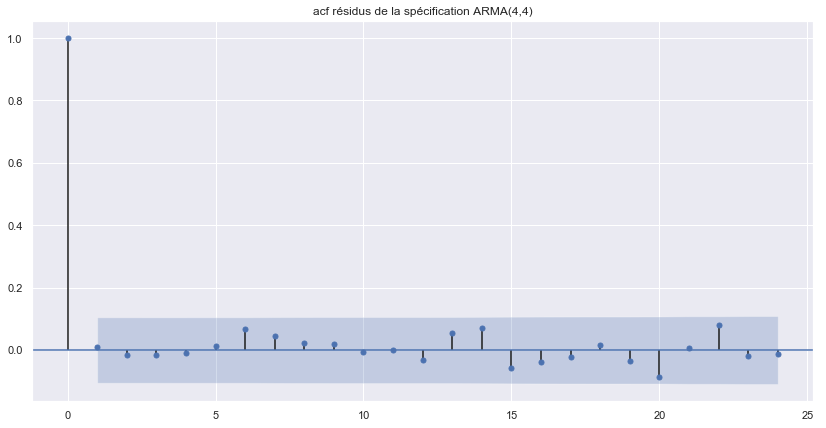

In [294]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(resid, lags=24,
             title=u"acf résidus de la spécification ARMA(4,4)")
    plt.savefig("Images/acf_arma.pdf")

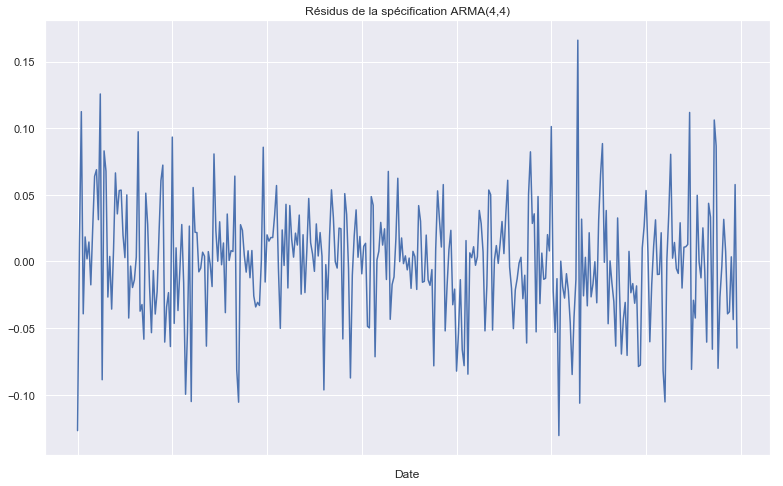

In [293]:
resid.plot(title=u"Résidus de la spécification ARMA(4,4)",legend=False, figsize=(13,8))
plt.savefig("Images/resid.pdf")
plt.show()

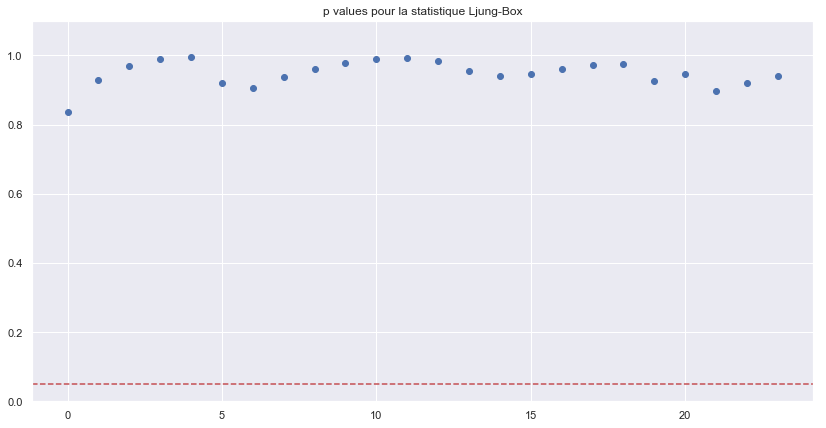

In [292]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plt.plot(acorr_ljungbox(resid)[1][0:24],'o')
    plt.axhline(y=0.05, color='r', linestyle='--')
    plt.title('p values pour la statistique Ljung-Box')
    plt.ylim([0,1.1])
    plt.savefig("Images/ljung_resid.pdf")

In [288]:
import scipy.stats as stats

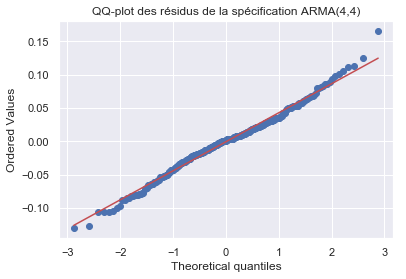

In [291]:
stats.probplot(resid, dist="norm", plot=plt)
plt.title("QQ-plot des résidus de la spécification ARMA(4,4)")
plt.savefig("Images/qqplot_resid.pdf")
plt.show()

## Sorties $\LaTeX$

### Tableau avec tous les modèles testés

In [229]:
def evaluate_arma_all(dataset, p_values, q_values):

    N = dataset.shape[0]
    train = dataset.iloc[1:(N-6)]
    test = dataset.iloc[(N-6):N]
    
    info_criterium, mse = pd.DataFrame([],columns=["order","AIC","BIC","MSE"]), None

    for p in p_values:

        for q in q_values:

            my_order = (p, q)

            try:

                model = ARMA(dataset, order=my_order)
                model_fit = model.fit()

                model_mse = ARMA(train, order=my_order).fit()
                pred = model_mse.forecast(6)[0]
                mse = mean_squared_error(pred,test)
                        
                info_criterium = info_criterium.append(pd.Series({"order":my_order,
                                                                "AIC":model_fit.aic,
                                                                "BIC":model_fit.bic,
                                                                "MSE":mse}),
                                                                 ignore_index=True)
                        
                        
                        

                pvalues_coef, mse = [], None

            except:

                print("je n'ai pas convergé : {}".format(my_order))
                continue
                
    #info_criterium.set_index("order",inplace=True)
    print("{} modèles sélectionnés".format(len(info_criterium)))
                

    return info_criterium

In [230]:
df_all = evaluate_arma_all(s, p_values, q_values)

je n'ai pas convergé : (0, 4)
je n'ai pas convergé : (5, 2)
je n'ai pas convergé : (5, 3)
je n'ai pas convergé : (5, 4)
je n'ai pas convergé : (6, 4)
35 modèles sélectionnés


In [233]:
print(df_all.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &   order &          AIC &          BIC &       MSE \\
\midrule
0  &  (0, 0) & -1042.137421 & -1034.427277 &  0.004712 \\
1  &  (0, 1) & -1171.858426 & -1160.293211 &  0.004452 \\
2  &  (0, 2) & -1179.292567 & -1163.872280 &  0.004522 \\
3  &  (0, 3) & -1177.481335 & -1158.205975 &  0.004538 \\
4  &  (1, 0) & -1101.850659 & -1090.285444 &  0.004636 \\
5  &  (1, 1) & -1179.678125 & -1164.257837 &  0.004543 \\
6  &  (1, 2) & -1177.705787 & -1158.430427 &  0.004544 \\
7  &  (1, 3) & -1175.731053 & -1152.600621 &  0.004542 \\
8  &  (1, 4) & -1177.157565 & -1150.172061 &  0.004539 \\
9  &  (2, 0) & -1129.818906 & -1114.398618 &  0.004360 \\
10 &  (2, 1) & -1177.703237 & -1158.427878 &  0.004543 \\
11 &  (2, 2) & -1177.641690 & -1154.511258 &  0.004773 \\
12 &  (2, 3) & -1176.177085 & -1149.191582 &  0.004842 \\
13 &  (2, 4) & -1178.521643 & -1147.681068 &  0.004749 \\
14 &  (3, 0) & -1131.530034 & -1112.254675 &  0.004385 \\
15 &  (3, 1) & -1175.784844 & -

### Tableau avec les modèles valides

In [234]:
def evaluate_arma_val(dataset, p_values, q_values):

    N = dataset.shape[0]
    train = dataset.iloc[1:(N-6)]
    test = dataset.iloc[(N-6):N]
    
    info_criterium, ljung_box, mse = pd.DataFrame([],columns=["order","AIC","BIC","MSE"]), None, None

    for p in p_values:

        for q in q_values:

            my_order = (p, q)

            try:

                model = ARMA(dataset, order=my_order)
                model_fit = model.fit()

                # On verifie que toutes les p-value du test de Ljung-box sont bien supérieures à 0.05
                ljung_box = np.min(acorr_ljungbox(model_fit.resid)[1])

                if ljung_box > 0.05:

                    model_mse = ARMA(train, order=my_order).fit()
                    pred = model_mse.forecast(6)[0]
                    mse = mean_squared_error(pred,test)
                        
                    info_criterium = info_criterium.append(pd.Series({"order":my_order,
                                                                "AIC":model_fit.aic,
                                                                "BIC":model_fit.bic,
                                                                "MSE":mse}),
                                                                 ignore_index=True)
                        
                        
                        

                    mse = None

            except:

                print("je n'ai pas convergé : {}".format(my_order))
                continue
                
    #info_criterium.set_index("order",inplace=True)
    print("{} modèles sélectionnés".format(len(info_criterium)))
                

    return info_criterium

In [235]:
df_val = evaluate_arma_val(s, p_values, q_values)

je n'ai pas convergé : (0, 4)
je n'ai pas convergé : (5, 2)
je n'ai pas convergé : (5, 3)
je n'ai pas convergé : (5, 4)
je n'ai pas convergé : (6, 4)
29 modèles sélectionnés


In [236]:
print(df_val.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &   order &          AIC &          BIC &       MSE \\
\midrule
0  &  (0, 2) & -1179.292567 & -1163.872280 &  0.004522 \\
1  &  (0, 3) & -1177.481335 & -1158.205975 &  0.004538 \\
2  &  (1, 1) & -1179.678125 & -1164.257837 &  0.004543 \\
3  &  (1, 2) & -1177.705787 & -1158.430427 &  0.004544 \\
4  &  (1, 3) & -1175.731053 & -1152.600621 &  0.004542 \\
5  &  (1, 4) & -1177.157565 & -1150.172061 &  0.004539 \\
6  &  (2, 1) & -1177.703237 & -1158.427878 &  0.004543 \\
7  &  (2, 2) & -1177.641690 & -1154.511258 &  0.004773 \\
8  &  (2, 3) & -1176.177085 & -1149.191582 &  0.004842 \\
9  &  (2, 4) & -1178.521643 & -1147.681068 &  0.004749 \\
10 &  (3, 1) & -1175.784844 & -1152.654412 &  0.004535 \\
11 &  (3, 2) & -1174.304274 & -1147.318771 &  0.004530 \\
12 &  (3, 3) & -1177.723612 & -1146.883037 &  0.004172 \\
13 &  (3, 4) & -1176.541449 & -1141.845802 &  0.004631 \\
14 &  (4, 1) & -1180.929642 & -1153.944138 &  0.004611 \\
15 &  (4, 2) & -1179.049131 & -

### Tableau avec les modèles valides et bon ajustement

In [237]:
print(df.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &   order &          AIC &          BIC &       MSE \\
\midrule
0 &  (0, 2) & -1179.292567 & -1163.872280 &  0.004522 \\
1 &  (1, 1) & -1179.678125 & -1164.257837 &  0.004543 \\
2 &  (2, 2) & -1177.641690 & -1154.511258 &  0.004773 \\
3 &  (2, 3) & -1176.177085 & -1149.191582 &  0.004842 \\
4 &  (3, 3) & -1177.723612 & -1146.883037 &  0.004172 \\
5 &  (4, 1) & -1180.929642 & -1153.944138 &  0.004611 \\
6 &  (4, 4) & -1181.339093 & -1142.788373 &  0.004092 \\
7 &  (5, 0) & -1165.807874 & -1138.822371 &  0.004742 \\
8 &  (7, 0) & -1169.640823 & -1134.945176 &  0.004242 \\
\bottomrule
\end{tabular}



### Prédictions de $X_{t+1}$ et $X_{t+2}$ à la main

In [13]:
# On se sert des mois de janvier et février qu'on a déjà dans la base comme base de test

test = s.iloc[-2:] #base qui contient janvier et février
s1 = s.iloc[:-2] #base qui exclut janvier et février

In [14]:
def lag_X(h): # fonction qui resort X_{t-h}
    return(s1.iloc[-h:].values[0][0])

def lag_ep(h): # fonction qui resort \epsilon_{t-h}
    return(arma_model.resid.iloc[-h-2:][0]) # -2 pour retirer janvier et février

In [15]:
def predict_t1(): # fonction qui predit X_{t+1} i.e. janvier
       
    ar = 0
    ma = 0
    
    for p in range(4):
        
        ar += arma_model.arparams[p]*lag_X(p+1)
        
    for q in range(4):
        
        ma += arma_model.arparams[q]*lag_ep(q+1)
        
    return(ar-ma)

In [16]:
def predict_t2(): # fonction qui predit X_{t+2} i.e. février
       
    ar = 0
    ma = 0
    
    for p in range(1,4):
        
        ar += arma_model.arparams[p]*lag_X(p+1)
        
    for q in range(1,4):
        
        ma += arma_model.arparams[q]*lag_ep(q+1)
        
    return(ar-ma+arma_model.arparams[0]*predict_t1())

In [17]:
print(predict_t1())
print(predict_t2())

0.03250866254681324
0.04797315730338642


### Construction de la région de confiance à 5%

In [22]:
from scipy.stats import chi2

In [24]:
phi1 = arma_model.arparams[0]
psi1 = arma_model.maparams[0]

ssr = sum(arma_model.resid.iloc[:-2]**2)
n = s1.shape[0]
sigma2 = ssr/(n-2)

hat_x1 = predict_t1()
hat_x2 = predict_t2()

alpha=0.05
cv = chi2.isf(q=1-alpha,df=2)

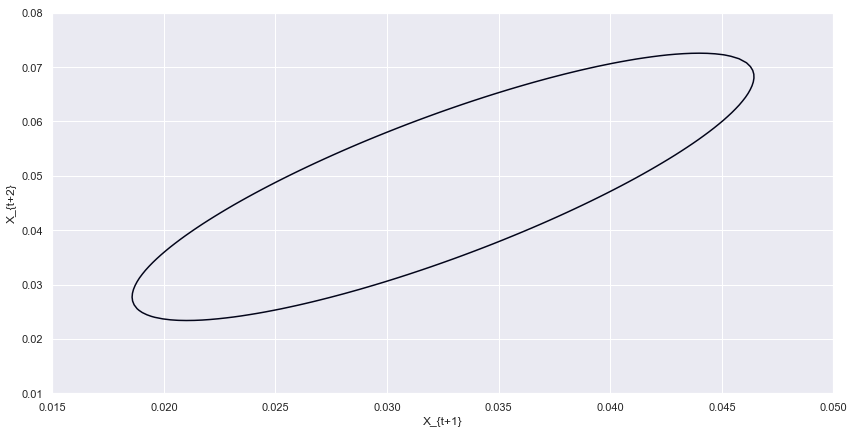

In [41]:
x = np.linspace(0.015, 0.05, 100)
y = np.linspace(0.01, 0.08, 100)

X, Y = np.meshgrid(x,y) # X = X_t+1, Y = X_t+2

F = cv - (1/sigma2)*((((psi1-phi1)*(X-hat_x1)+(Y-hat_x2))**2)+((X-hat_x1)**2)) # équation de l'ellipse

with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))
    plt.contour(X,Y,F,[0])
    plt.xlabel('X_{t+1}')
    plt.ylabel('X_{t+2}')
    plt.show()

### Plot des prédictions

In [270]:
# On rajoute les prédictions de X_{t+1} et X_{t+2} dans la table initiale - méthode avec la fonction forecast
df2 = pd.DataFrame([[arma_model.forecast(steps=2)[0][0]], [arma_model.forecast(steps=2)[0][1]]], columns=["Electricite"], index=["2019-01-01","2019-02-01"])
s2 = s1.append(df2)

In [274]:
# On rajoute les prédictions de X_{t+1} et X_{t+2} dans la table initiale - méthode à la main
df3 = pd.DataFrame([[predict_t1()], [predict_t2()]], columns=["Electricite"], index=["2019-01-01","2019-02-01"])
s2 = s1.append(df3)

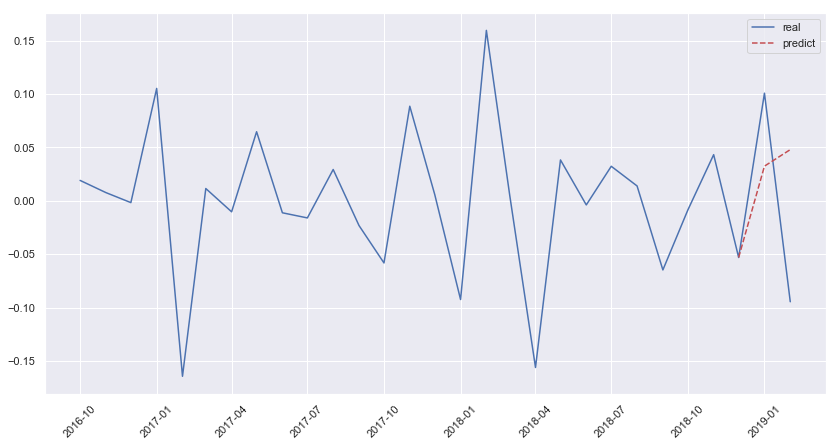

In [275]:
with mpl.rc_context():
    
    mpl.rc("figure", figsize=(14,7))

    g1 = plt.plot(s.iloc[320:s.shape[0]], label="real")
    g2 = plt.plot(s2.iloc[s2.shape[0]-3:s2.shape[0]],'--r', label="predict") # predict, et on récupère le mois d'avant pour que le plot soit plus jolie
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    plt.savefig("Images/predvsreal.png")